In [79]:
import numpy as np
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
from sklearn import datasets

In [87]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei



def KWSA(F, w, m, c, d):
    """ 
    Kiefer-Wolfowitz stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample size (null in this case)
    - d: dimension
    - c: costant
    
    """

    F_wc = np.array([F(w + c * e(i, d)) for i in range(d)])
    return (F_wc - F(w)) / c




def IRDSA(F, w, m, c, d):
    """ 
    Improvised Random Direction stochastic approximation
    for gradient estimation 
    
    INPUT:
    - F: objective function
    - w: current weight
    - m: sample dimension
    - d: features dimension
    - c: costant
    
    """
    z = np.random.normal(0, 1, (d, m))
    F_w = F(w)
    return np.mean([(F(w + c * z[:,i]) - F_w) / c * z[:,i] for i in range(m)], axis = 0)
    
    


def detZFW(F, L, d, w0, r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - L: Lip constant
    - d: dimension
    - w0: starting point
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """

    gamma = lambda t: 2/(t+2)
    c = lambda t: L*gamma(t)/d
    w = w0
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = KWSA(F, w, None, c(t), d)
        # compute the linear problem solution on the L1 Ball of radius r
        i_k = np.argmax(np.abs(gt))
        ei = e(i_k, d) * r
        v = np.sign(-gt[i_k]) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = F(w_pred) - F(w)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.7f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t

## Stochastic lasso regression

In [81]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [82]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [83]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [141]:
# initialize prarameters for the algorithm

# stating point 
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)
#print(w0)
#print(F(w0))
# Lipschitz constant computation
L = 3 #np.linalg.norm(X.dot(w0))
print(f"L: {L}")

indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
print(f"w0: {w0}")

L: 3
w0: [0.01427508 0.         0.00015906 0.         0.01389659 0.00688839
 0.         0.         0.01932185 0.01479194 0.02022282 0.00448395
 0.00748594 0.01342289 0.01271894 0.02491499 0.02041378 0.00027417
 0.00842006 0.00915197 0.02134084 0.01812206 0.         0.00217311
 0.02532913 0.         0.01866816 0.         0.         0.00976202
 0.         0.         0.         0.         0.0048263  0.00815502
 0.         0.00240203 0.01385256 0.0026268  0.02195627 0.02554037
 0.         0.         0.00559095 0.02190458 0.01865861 0.
 0.01393978 0.         0.00446371 0.00612003 0.0110981  0.021799  ]


In [142]:
%%time
fpred, f, w_det, mean, t = detZFW(F, L, d, w0, T=100)

Loss evaluation at time 1:	0.6434678

Loss evaluation at time 2:	0.1126711

Loss evaluation at time 3:	0.0396705

Loss evaluation at time 4:	0.0186785

Loss evaluation at time 5:	0.0103272

Loss evaluation at time 6:	0.0063267

Loss evaluation at time 7:	0.0041631

Loss evaluation at time 8:	0.0028882

Loss evaluation at time 9:	0.0020870

Loss evaluation at time 10:	0.0015578

Loss evaluation at time 11:	0.0011940

Loss evaluation at time 12:	0.0009355

Loss evaluation at time 13:	0.0007467

Loss evaluation at time 14:	0.0006056

Loss evaluation at time 15:	0.0004980

Loss evaluation at time 16:	0.0004145

Loss evaluation at time 17:	0.0003487

Loss evaluation at time 18:	0.0002961

Loss evaluation at time 19:	0.0002536

Loss evaluation at time 20:	0.0002189

Loss evaluation at time 21:	0.0001902

Loss evaluation at time 22:	0.0001664

Loss evaluation at time 23:	0.0001464

Loss evaluation at time 24:	0.0001294

Loss evaluation at time 25:	0.0001150

Loss evaluation at time 26:	0.0001

In [143]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w_det}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.1586989989974017

F(w_pred) = 0.30946125867317376

F(w) = 0.30945146089466885

w = [8.06501705e-06 0.00000000e+00 8.98646933e-08 0.00000000e+00
 7.85118183e-06 3.89174810e-06 0.00000000e+00 9.99435028e-01
 1.09162988e-05 8.35702561e-06 1.14253214e-05 2.53330594e-06
 4.22934586e-06 7.58355126e-06 7.18584115e-06 1.40762660e-05
 1.15332112e-05 1.54897320e-07 4.75709568e-06 5.17060659e-06
 1.20569735e-05 1.02384500e-05 0.00000000e+00 1.22774416e-06
 1.43102433e-05 0.00000000e+00 1.05469819e-05 0.00000000e+00
 0.00000000e+00 5.51526653e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.72672452e-06 4.60735805e-06
 0.00000000e+00 1.35707673e-06 7.82630471e-06 1.48406801e-06
 1.24046722e-05 1.44295881e-05 0.00000000e+00 0.00000000e+00
 3.15873095e-06 1.23754668e-05 1.05415862e-05 0.00000000e+00
 7.87558191e-06 0.00000000e+00 2.52187150e-06 3.45764426e-06
 6.27011077e-06 1.23158219e-05]

average w = [1.37992442e-04 0.00000000e+00 1.53758490e-06 0.00000000e+00

## Stochastic Gradient Free Frank Wolfe

In [144]:
def stochasticZFW(F, d,  w0, method = "IRDSA", r=1, T=100, eps=1e-5):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - method: zeroth order oracle
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    Parameters_dict = {"KWSA": {"m": None, 
                                "c": lambda t: 2 / (np.sqrt(d) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / np.power(t+8, 2/3),
                                "oracle": KWSA},
                       
                   
                       "RDSA": {"m": 1, 
                                "c": lambda t: 2 / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(d, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA},
                   
                       "IRDSA": {"m": 6, 
                                "c": lambda t: 2 * np.sqrt(6) / (np.power(d, 3/2) * np.power(t+8, 1/3)),
                                "p": lambda t: 4 / (np.power(1+d/6, 1/3) * np.power(t+8, 2/3)),
                                "oracle": IRDSA}
                  
                        }
    
    return sZFW(F, d, w0, Parameters_dict[method], r, T, eps)
    
  

    
def sZFW(F, d, w0, params, r, T, eps):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - params: dict of parameters for the selected method
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    loss = []
    gamma = lambda t: 2/(t+8)
    w = w0
    dt = np.zeros(d)
    partial = 0
    for t in range(1, T+1):
        # comupute the gradient approx
        gt = params["oracle"](F, w, params["m"], params["c"](t), d)
        dt = (1 - params["p"](t)) * dt + params["p"](t) * gt
        # compute the linear problem solution on the L1 Ball of radius r
        ei = e(np.argmax(np.abs(dt)), d) * r
        v = np.sign(-dt) * ei
        # compute step 
        w_pred = w
        w = (1 - gamma(t)) * w + gamma(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.7f}\n")
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss


In [145]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=1, T=100, eps=1e-5)

Loss evaluation at time 1:	0.0109030

Loss evaluation at time 2:	0.0166389

Loss evaluation at time 3:	0.2074434

Loss evaluation at time 4:	0.0721850

Loss evaluation at time 5:	0.0312891

Loss evaluation at time 6:	0.0997247

Loss evaluation at time 7:	0.0255838

Loss evaluation at time 8:	0.0472122

Loss evaluation at time 9:	0.0643322

Loss evaluation at time 10:	0.0509400

Loss evaluation at time 11:	0.0455933

Loss evaluation at time 12:	0.0027826

Loss evaluation at time 13:	0.0359570

Loss evaluation at time 14:	0.0262340

Loss evaluation at time 15:	0.0256478

Loss evaluation at time 16:	0.0185212

Loss evaluation at time 17:	0.0158879

Loss evaluation at time 18:	0.0137342

Loss evaluation at time 19:	0.0148630

Loss evaluation at time 20:	0.0129855

Loss evaluation at time 21:	0.0088704

Loss evaluation at time 22:	0.0103234

Loss evaluation at time 23:	0.0091657

Loss evaluation at time 24:	0.0059770

Loss evaluation at time 25:	0.0053577

Loss evaluation at time 26:	0.0048

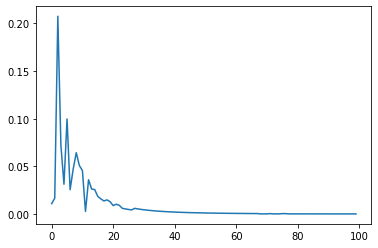

In [146]:
plt.plot(loss)

In [147]:
print(f'OUTPUT:\n\nF(w0) = {f}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.1586989989974017

F(w_pred) = 0.33038951584565174

F(w) = 0.3305297578114198

w = [ 4.39593324e-03  2.07684320e-03  7.70802042e-07  0.00000000e+00
  6.73424319e-05  3.33809339e-05  5.13326411e-01  4.66597439e-01
  9.36330510e-05  7.16812373e-05  3.38633419e-03  2.17290831e-05
  3.62766322e-05  6.50468675e-05  6.16355638e-05  1.20737235e-04
  9.89245322e-05  1.32861045e-06  4.08033337e-05  4.43501666e-05
  1.03417032e-04  8.78188960e-05  0.00000000e+00  2.60658480e-03
  1.22744143e-04  0.00000000e+00  9.04652863e-05  0.00000000e+00
  0.00000000e+00  4.73064398e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.33881044e-05  3.95189798e-05
  1.38456213e-03  1.16401389e-05  6.71290519e-05  1.27293892e-05
 -1.45123303e-03  1.23767806e-04  0.00000000e+00  0.00000000e+00
  2.70935801e-05  1.06148863e-04  9.04190052e-05  0.00000000e+00
  6.75517202e-05  0.00000000e+00  2.16310058e-05  2.96574679e-05
  5.37810124e-05  1.05637268e-04]

average w = [ 3.629

## Zeroth order stochastic accelerated gradient method with inexact updates

In [21]:
def InexactUpdate(g, d, v, r, gamma, mu):
    """
    INPUT
    - g: gradient approximation 
    - d: dimension
    - v: starting point
    - r: radius
    - gamma: decreasing coefficient
    - mu: threshold
    """
    
    haty = v
    t = 1
    while True:
        # ARGMIN PROBLEM
        ht1 = g + gamma*(haty - v)
        i_k = np.argmax(np.abs(ht1))
        ei = e(i_k, d) * r
        yt = np.sign(-ht1[i_k]) * ei
        if np.dot(ht1, yt - haty) >= - mu:
            break
        else:
            haty = (t-1)/(t+1) * haty + 2/(t+1)*yt
            t +=1
    return haty
    

L = 3
D = 2*r*10 # we will start from m = 6, up to T * (T+1) / D * (d+3)
B = 1


def IZFW(F, d, w0, L, B, D, r = 1, T = 100, eps = 1e-6):
    """
    INPUT
    - F: loss function
    - d: dimension
    - w0: starting point
    - L: lipschitz
    - B: 1
    - D: number greater than diamater l1 ball
    - r: radius of the ball
    - T: max iteration
    - eps: tolerance
    """
    
    alpha = lambda t: 2/(t+2)
    gamma = lambda t: 4*L/t
    mu = lambda t: L*D/(t*T)
    m = lambda t: t * (t+1) / D * (d+3)#np.max([(d+5)*B*T, d+3])
    c = 1 / (np.sqrt(2*T)) * np.max([1/(d+3), np.sqrt(D/(d*(T+1)))]) # smoothing parameter now fixed
    
    loss = []
    v, w = w0, w0
    partial = 0
    
    for t in range(1, T+1):
        dt = (1-alpha(t)) * w + alpha(t) * v
        g = IRDSA(F, dt, int(np.ceil(m(t))), c, d)
        v = InexactUpdate(g, d, v, r, gamma(t), mu(t)) #ICG
        w_pred = w
        w = (1 - alpha(t)) * w + alpha(t) * v
        partial += w
        loss_eval = np.abs(F(w_pred) - F(w))
        loss.append(loss_eval)
        print(f"Loss evaluation at time {t}:\t{loss_eval:.7f}\n")
        print(int(np.ceil(m(t))))
        if loss_eval < eps: break # check stopping condition
    return F(w_pred), F(w), w, partial/T, t, loss

I parametri degli algoritmi (L per deterministic FW e IGC + tutti quelli di IGC che sono collegati al gradiente, tipo varianza del grad e grad stesso)

I grafici uguali o no? Che differenza c'è tra # oracolo e # di iterazioni? (Loss disponibile solo a fine chiamate oracolo)

I dataset: il primo ok, secondo stesso preprocessing ma abbiamo risultati diversi, il terzo non sappiamo cos'è e come si usa.



In [22]:
%%time
fpred, f, w, mean, t, loss = IZFW(F, d, w0, L, B, r = 1, T = 100, eps = 1e-3)

Loss evaluation at time 1:	343218.6203

57
Loss evaluation at time 2:	60852.1867

171
Loss evaluation at time 3:	21546.1982

342
Loss evaluation at time 4:	10174.2399

570
Loss evaluation at time 5:	5634.6010

855
Loss evaluation at time 6:	199.7743

1197
Loss evaluation at time 7:	3182.5927

1596
Loss evaluation at time 8:	967.1668

2052
Loss evaluation at time 9:	2234.7473

2565
Loss evaluation at time 10:	1091.7662

3135
Loss evaluation at time 11:	935.3902

3762
Loss evaluation at time 12:	1803.3786

4446


KeyboardInterrupt: 

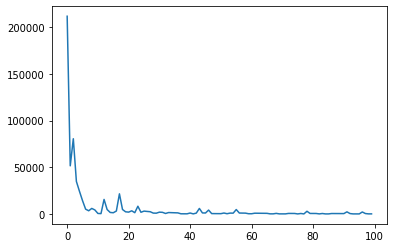

In [23]:
plt.plot(loss)

In [24]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')# m=6, T=1000

OUTPUT:

F(w_pred) = 197914.107239128

F(w) = 197869.3747248715

w = [2.34933557e-02 4.02983567e-06 3.08795393e-08 3.61756009e-06
 3.69130200e-03 1.33729259e-06 4.01673147e-01 5.04176608e-01
 4.69849198e-02 2.87166285e-06 1.98059062e-02 8.70501166e-07
 1.45329881e-06 2.60587958e-06 2.46921740e-06 4.83692308e-06
 3.96307199e-06 5.32262194e-08 1.63464558e-06 1.77673727e-06
 4.14304857e-06 3.51816278e-06 4.02127965e-06 4.21880637e-07
 4.91732298e-06 4.98055814e-06 3.62418132e-06 8.70545149e-07
 2.30748277e-06 1.89517021e-06 4.86767458e-06 8.97616203e-07
 4.09760962e-06 2.50305167e-06 9.36964163e-07 1.58319234e-06
 3.75474925e-06 4.66322230e-07 2.68929516e-06 5.09959305e-07
 4.26252570e-06 4.95833253e-06 2.29084708e-06 1.23152751e-06
 1.08541133e-06 4.25249003e-06 3.62232723e-06 4.27706155e-06
 2.70622791e-06 2.62828100e-07 8.66572037e-07 1.18812470e-06
 2.15455175e-06 4.23199472e-06]

average w = [5.64144616e-02 2.03506701e-04 1.55941674e-06 1.82686785e-04
 1.64107509e-02 6.75332759e-05 4

In [61]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')#100

OUTPUT:

F(w_pred) = 198152.00822366346

F(w) = 198018.65622128965

w = [4.47739238e-02 1.14471662e-03 4.80743181e-09 5.63194071e-07
 4.20009460e-07 2.08194264e-07 3.76933956e-01 5.25665416e-01
 2.27723602e-02 4.47070249e-07 2.64906774e-02 1.35522585e-07
 2.20039787e-03 4.05692205e-07 3.84416172e-07 7.53028653e-07
 6.16984540e-07 8.28643904e-09 2.54487188e-07 2.76608507e-07
 6.45003906e-07 5.47719559e-07 6.26046507e-07 6.56798139e-08
 7.65545583e-07 7.75390248e-07 5.64224887e-07 1.35529433e-07
 3.59236773e-07 2.95046551e-07 7.57816151e-07 1.39743946e-07
 6.37929816e-07 3.89683605e-07 1.45869771e-07 2.46476774e-07
 5.84552147e-07 7.25986323e-08 4.18678626e-07 7.93922008e-08
 6.63604513e-07 7.71930090e-07 3.56646873e-07 1.91728395e-07
 1.68980532e-07 6.62042126e-07 5.63936236e-07 6.65867503e-07
 4.21314775e-07 4.09179734e-08 1.34910885e-07 1.84971298e-07
 3.35427952e-07 6.58851346e-07]

average w = [2.18088624e-02 5.61318427e-03 7.23518488e-07 8.47607077e-05
 6.32114238e-05 3.13332367e-0

In [148]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy")
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n

In [149]:
f_star = 0.30945146089466885

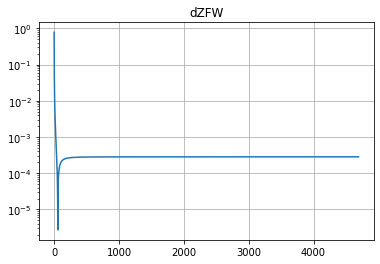

In [150]:
F_eval = np.abs(f_d - f_star)
plt.plot(F_eval[:-100])
plt.yscale("log")
plt.title("dZFW")
plt.grid()

In [151]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy")
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

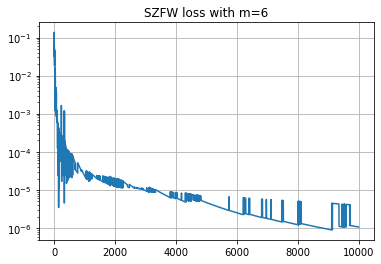

In [160]:
plt.plot(loss_stochm6/n)
plt.yscale("log")
plt.title("SZFW loss with m=6")
plt.grid()

In [152]:
f_star

0.30945146089466885

In [161]:
f_star = np.min(f_stochm6)

In [162]:
10000/6

1666.6666666666667

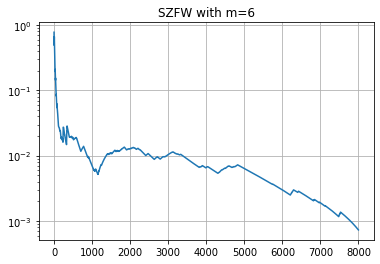

In [164]:
F_eval = np.abs(f_stochm6 - f_star)
plt.plot(F_eval[:8000])
plt.yscale("log")
plt.title("SZFW with m=6")
plt.grid()

In [137]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy")
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

In [138]:
np.min(f_stochm1)

0.31362871769382883

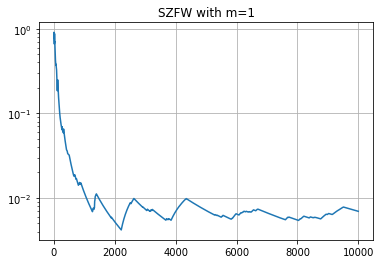

In [139]:
F_eval = np.abs(f_stochm1 - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("SZFW with m=1")
plt.grid()

In [46]:
a_ = X.toarray()

In [51]:
a_[:,52]

array([0., 0., 0., ..., 0., 0., 0.])